In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
line_type = {'solid line' : 'solid', ## 라인 유형
             'dashed line' : 'dashed',
             'dash-dotted line' : 'dashdot',
             'dotted line' : 'dotted'}

In [3]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [4]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [5]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [6]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [7]:
train_data.shape,test_data.shape

((210,), (60,))

In [8]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


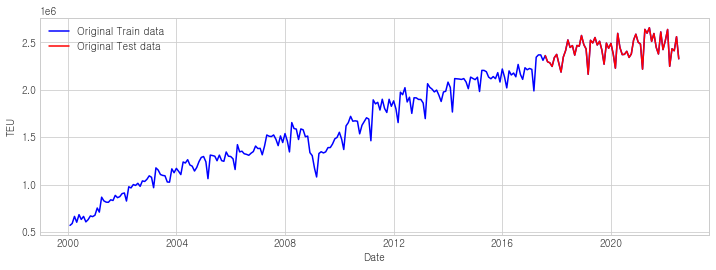

In [9]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Original Train data')
plt.plot(test_data, 'red', label='Original Test data')
plt.legend()

### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

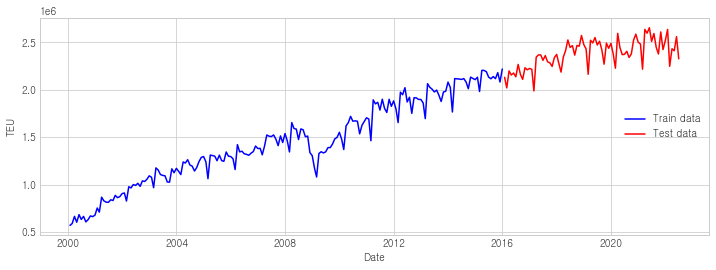

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend(loc=5)

In [17]:
len(train),len(test)

(192, 78)

In [19]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [21]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [22]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 12   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [23]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [24]:
X_train.shape,Y_train.shape

((163, 18, 10), (163, 12, 1))

### 2. X_test,Y_test 배열

In [25]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_test= X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_test= Y 종속변수 예측값 

In [26]:
X_test.shape,Y_test.shape

((49, 18, 10), (49, 12, 1))

In [27]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [28]:
n_hidden = 64
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(Y_train.shape[1], Y_train.shape[2]))

encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='tanh',return_state = True, return_sequences=True)(input_train)

encoder_stack_h = MCDropout(0.8)(encoder_stack_h)
encoder_last_h = MCDropout(0.8)(encoder_last_h)
encoder_last_c = MCDropout(0.8)(encoder_last_c)

decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)

decoder_stack_h = LSTM(n_hidden, activation = 'tanh',
                       return_state =False , 
                       return_sequences = True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

decoder_stack_h = MCDropout(0.8)(decoder_stack_h)

attention = dot([decoder_stack_h, encoder_stack_h], axes = [2,2])
attention = Activation('softmax')(attention)

context = dot([attention, encoder_stack_h], axes = [2,1])

decoder_combined_context = concatenate([context, decoder_stack_h])

out = TimeDistributed(Dense(8,activation='relu'))(decoder_combined_context)
out = TimeDistributed(Dense(1))(out)

model = Model(inputs=input_train, outputs = out)
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics = ['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
16/16 [==============================] - 9s 304ms/step - loss: 0.2616 - mae: 0.4352 - val_loss: 0.0832 - val_mae: 0.2374
Epoch 2/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0687 - mae: 0.1980 - val_loss: 0.0884 - val_mae: 0.2715
Epoch 3/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0341 - mae: 0.1471 - val_loss: 0.0351 - val_mae: 0.1536
Epoch 4/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0258 - mae: 0.1267 - val_loss: 0.0491 - val_mae: 0.1794
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: 0.0241 - mae: 0.1229 - val_loss: 0.0555 - val_mae: 0.2007
Epoch 6/200
16/16 [==============================] - 0s 19ms/step - loss: 0.0206 - mae: 0.1137 - val_loss: 0.0278 - val_mae: 0.1370
Epoch 7/200
16/16 [==============================] - 0s 23ms/step - loss: 0.0180 - mae: 0.1055 - val_loss: 0.0338 - val_mae: 0.1407
Epoch 8/200
16/16 [==============================] - 0s 19ms/step - loss: 0

In [29]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

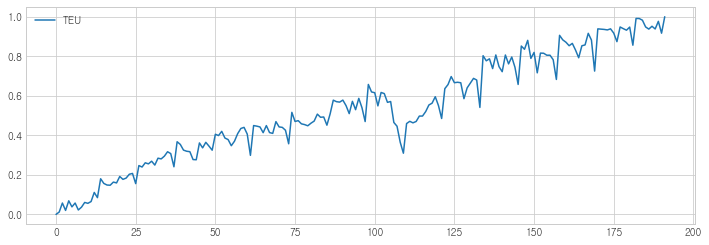

In [30]:
label_train.plot()

<AxesSubplot:>

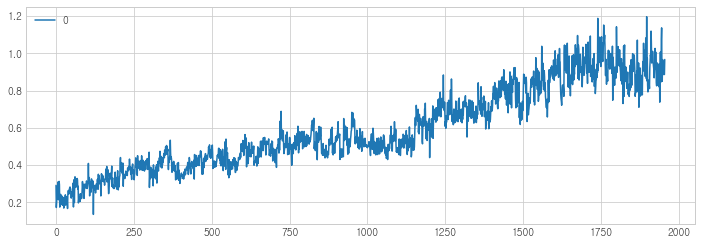

In [31]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

#### Most Probable Explanation

### 1. 2017.07 ~ 2018.06

In [32]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [33]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [34]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

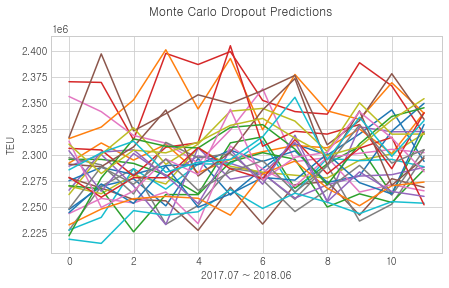

In [35]:
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2018.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [36]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [37]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [38]:
np.mean(df.std()/df.mean())

0.010158873163163662

In [40]:
rmse = math.sqrt(mean_squared_error(trend[0:12].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:12].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:12].reset_index()['TEU_Trend'])*100) )

RMSE: 57260.36860413151
MAPE: 2.0776248064919502


In [41]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[:12]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2247395.5,2292041.0,2295701.25,2370544.0,2265958.0,2277900.0,2356318.25,2227302.0,2269884.5,2227492.25,2275060.75,2315679.5,2270246.75,2306306.5,2289152.75,2316732.25,2243425.5,2297247.25,2261739.25,2218689.25,2244259.75,2232513.0,2221993.25,2278322.75,2303953.0,2291006.75,2313242.75,2248003.0,2310330.0,2285553.75


In [42]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:222]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2018-06-30,2443990,1385,2.926085,2.901474,4.385095,110.3,7980.1,1092.8,137274768,103.55


Mean RMSE: 97046.67774441928
Mean MAPE: 3.219095412088778


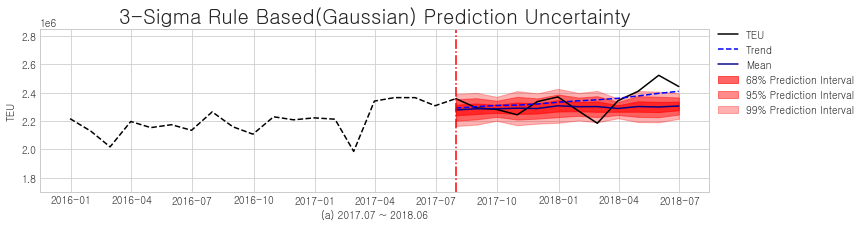

In [43]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='red', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='red',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().mean())/ test_data.head(12).reset_index()['TEU'])*100) )

In [42]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5
추세 변동에 대한 포함확률: 0.5


Median RMSE: 97183.46438259775
Median MAPE: 3.180012081464825


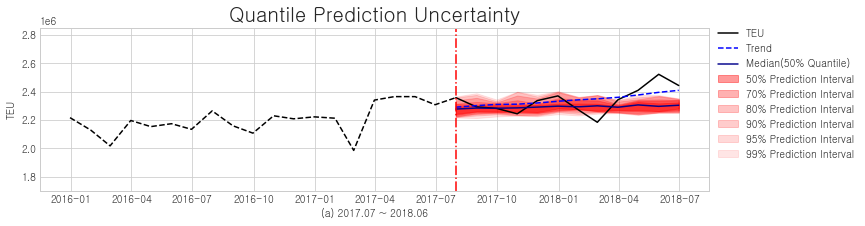

In [43]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='red', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='red', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='red', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='red', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='red', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.head(12).reset_index()['TEU'])*100) )

In [44]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5833333333333334
추세 변동에 대한 포함확률: 0.3333333333333333


In [45]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 68904.086
Quantile 70% Interval Sharpness 63657.560416666754


RMSE: 93222.02205303342
MAPE: 3.0967084205227025


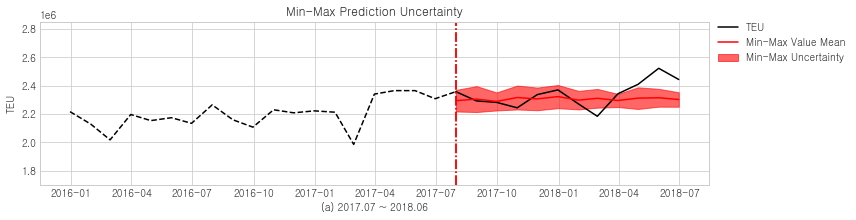

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Min-Max Prediction Uncertainty')
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')
plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='red',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='red',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='red',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='red',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.head(12).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [47]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5833333333333334


In [48]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 137808.38
Quantile 95% Interval Sharpness 123906.14791666658
Min Max Interval Sharpness 140822.88


In [49]:
import CRPS.CRPS as pscore

In [50]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(12).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

60002.08888888889
8594.961666666666
7069.733611111112
27518.502500000002
34718.77055555556
47580.139444444445
16849.01416666667
97322.7763888889
42322.466944444444
86823.58666666667
203531.24333333332
120572.11


In [51]:
a = np.array([60002.08888888889,
8594.961666666666,
7069.733611111112,
27518.502500000002,
34718.77055555556,
47580.139444444445,
16849.01416666667,
97322.7763888889,
42322.466944444444,
86823.58666666667,
203531.24333333332,
120572.11])

In [52]:
np.mean(a)

62742.11618055555

In [53]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2295180.8

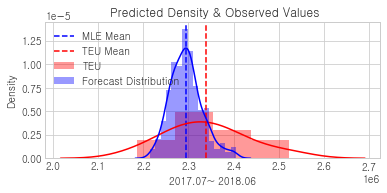

In [54]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(12).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017.07~ 2018.06')
plt.legend(loc=2)

In [55]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(12).reset_index()['TEU'].mean(), scale=test_data.head(12).reset_index()['TEU'].std() ) )
LL

4513.310889697418

In [56]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

6171.524223425202

In [57]:
LL = -np.sum( stats.norm.logpdf(test_data.head(12).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

780.1984419186431

In [58]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [59]:
for i in range(0,30):
    print(KL(df[i],test_data.head(12).reset_index()['TEU']))

584218.0452152014
369164.95499786065
532086.150344509
307182.07260568225
477486.0697469314
908215.0278010198
231753.5290007159
856886.6576358103
602610.8030596388
681383.1423443061
490200.568148628
182632.22068309414
799261.447210774
219539.85318629007
701569.2574482467
138235.62099846435
814639.2638173226
633461.488687254
239096.6677860288
1071717.0924342175
742912.1461887994
889644.4807717071
385906.23976783024
601298.2663153952
668261.0345398141
300740.58041630645
477201.2842849371
611754.0236277567
259655.041869
330477.66013539064


In [60]:
a = np.array([584218.0452152014,
369164.95499786065,
532086.150344509,
307182.07260568225,
477486.0697469314,
908215.0278010198,
231753.5290007159,
856886.6576358103,
602610.8030596388,
681383.1423443061,
490200.568148628,
182632.22068309414,
799261.447210774,
219539.85318629007,
701569.2574482467,
138235.62099846435,
814639.2638173226,
633461.488687254,
239096.6677860288,
1071717.0924342175,
742912.1461887994,
889644.4807717071,
385906.23976783024,
601298.2663153952,
668261.0345398141,
300740.58041630645,
477201.2842849371,
611754.0236277567,
259655.041869,
330477.66013539064])

In [61]:
np.mean(a)

536973.023035631

### 2. 2018.07 ~ 2019.06

In [39]:
X_test_2 = np.array(feature_test[12:30]).reshape((1, 18, 10)) 

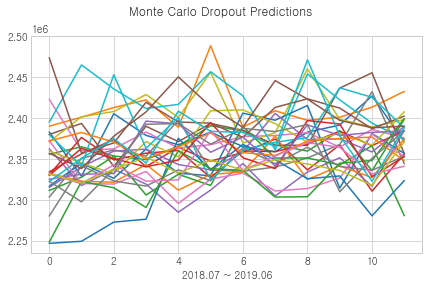

In [40]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2018.07 ~ 2019.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [41]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [42]:
np.mean(df.std()/df.mean())

0.011543049477040768

In [49]:
rmse = math.sqrt(mean_squared_error(trend[12:24].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[12:24].reset_index()['TEU_Trend']- df.transpose().median())/ trend[12:24].reset_index()['TEU_Trend'])*100) )

RMSE: 81119.03032380718
MAPE: 3.301277831023428


In [50]:
df.to_csv('Attention.csv')

In [67]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[12:24]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-31,2383498.25,2390530.75,2356370.25,2334699.5,2363014.25,2380394.0,2423316.25,2303909.0,2371469.25,2395232.0,2317295.75,2332979.75,2312034.25,2331217.25,2315762.75,2474042.75,2372711.25,2280785.75,2360200.75,2380036.0,2247490.5,2372466.0,2248923.25,2330397.75,2325730.25,2357420.0,2332046.75,2323312.75,2332579.0,2322920.0


In [68]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:234]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2019-06-30,2469920,1354,2.840263,2.897122,4.424881,109.8,6166.1,1175.62,140568904,100.79


Mean RMSE: 132481.40894094977
Mean MAPE: 4.949075160930602


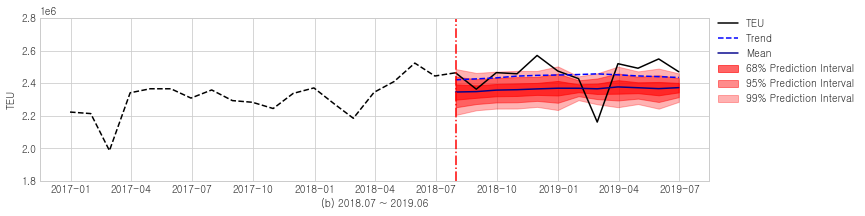

In [69]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='red', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='red',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [70]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.08333333333333333
추세 변동에 대한 포함확률: 0.0


Median RMSE: 134293.58657525232
Median MAPE: 5.050326024341645


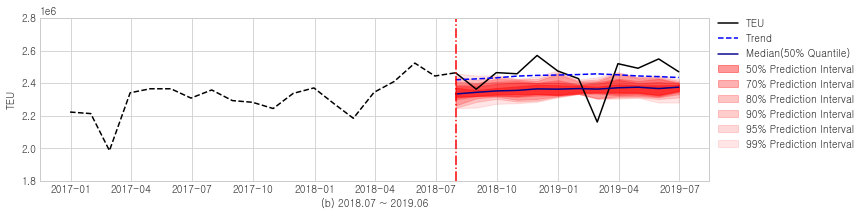

In [71]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='red', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='red', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='red', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='red', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='red', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [72]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.08333333333333333
추세 변동에 대한 포함확률: 0.0


In [73]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 73921.04
Quantile 70% Interval Sharpness 67884.51354166656


RMSE: 129824.05487217354
MAPE: 4.7533518890680275


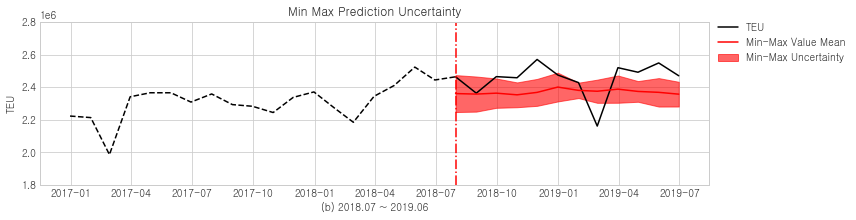

In [74]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='red',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='red',alpha=0.6, label='Min-Max Uncertainty')

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [75]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.25


In [76]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 147842.0
Quantile 95% Interval Sharpness 132567.52760416668
Min Max Interval Sharpness 164278.17


In [77]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[12:24].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

93591.50833333333
11699.507777777775
87146.89472222223
76231.79
184849.76750000002
82511.50194444445
45735.44388888888
186771.3827777778
119817.9186111111
100998.02694444446
159255.75583333333
81962.15138888889


In [78]:
a = np.array([93591.50833333333,
11699.507777777775,
87146.89472222223,
76231.79,
184849.76750000002,
82511.50194444445,
45735.44388888888,
186771.3827777778,
119817.9186111111,
100998.02694444446,
159255.75583333333,
81962.15138888889])

In [79]:
np.mean(a)

102547.63747685186

In [80]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2363922.8

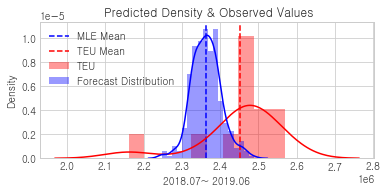

In [81]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[12:24].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[12:24].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2018.07~ 2019.06')
plt.legend(loc=2)

In [82]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[12:24].reset_index()['TEU'].mean(), scale=test_data.iloc[12:24].reset_index()['TEU'].std() ) )
LL

4640.9250894693505

In [83]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

6470.815452720734

In [84]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[12:24].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

1294.1056442366416

In [85]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[12:24].reset_index()['TEU']))

831114.364416956
431608.639486992
952642.1858556333
1132681.3089214729
1375555.8990158488
737428.9368389111
843950.650474169
1091138.0892452705
515875.3338057997
369406.7377227554
1068535.4509187688
1298531.6127534702
1315932.132026694
1038068.834247174
1035518.5159414245
550993.3322837224
1363160.2686501658
1321083.6207019961
864054.0092834502
753053.4264295385
1593221.8379501102
960167.3241877351
1433754.434720216
1073295.4509684867
977341.5713618854
593649.9569733322
1228408.755771702
1038961.5446131289
1270998.448416946
874080.2113922656


In [86]:
a = np.array([831114.364416956,
431608.639486992,
952642.1858556333,
1132681.3089214729,
1375555.8990158488,
737428.9368389111,
843950.650474169,
1091138.0892452705,
515875.3338057997,
369406.7377227554,
1068535.4509187688,
1298531.6127534702,
1315932.132026694,
1038068.834247174,
1035518.5159414245,
550993.3322837224,
1363160.2686501658,
1321083.6207019961,
864054.0092834502,
753053.4264295385,
1593221.8379501102,
960167.3241877351,
1433754.434720216,
1073295.4509684867,
977341.5713618854,
593649.9569733322,
1228408.755771702,
1038961.5446131289,
1270998.448416946,
874080.2113922656])

In [87]:
np.mean(a)

997807.0961792007

### 3. 2019.07 ~ 2020.06

In [43]:
X_test_3 = np.array(feature_test[24:42]).reshape((1, 18, 10)) 

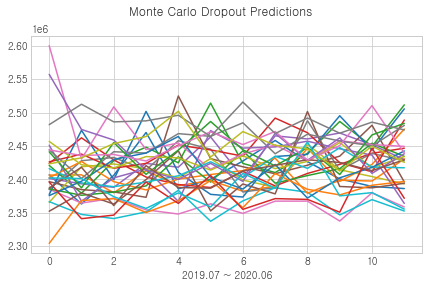

In [44]:
model_MC=  model
prediction = [model_MC.predict(X_test_3) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2020.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [45]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [46]:
np.mean(df.std()/df.mean())

0.011854796670377254

In [47]:
df.to_csv('Attention.csv')

In [55]:
rmse = math.sqrt(mean_squared_error(trend[24:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[24:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[24:36].reset_index()['TEU_Trend'])*100) )

RMSE: 20837.562686584108
MAPE: 0.7319739362843626


In [93]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[24:36]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2406904.25,2406521.25,2421014.25,2423970.75,2401442.75,2396728.5,2385464.0,2385294.0,2365808.25,2366822.25,2377705.0,2402726.75,2385899.25,2426370.0,2451208.5,2352479.0,2600107.75,2444355.0,2456944.75,2416172.75,2375863.5,2304375.25,2441314.5,2396057.5,2557244.75,2387391.25,2444265.75,2481975.25,2423371.75,2402261.25


In [94]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2020-06-30,2371415,1799,2.70092,2.992441,4.411836,110.4,7039.3,1210.01,116998896,95.01


Mean RMSE: 96844.41131413444
Mean MAPE: 3.2617427882953787


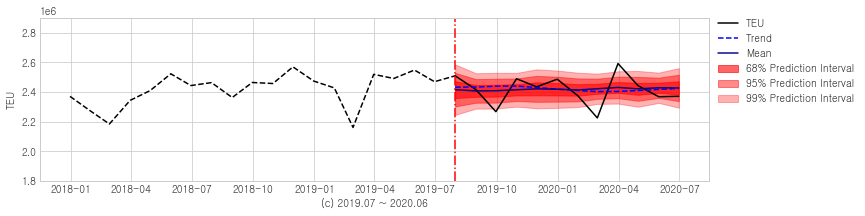

In [95]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.9e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='red', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='red',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [96]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 1.0


Median RMSE: 97921.8479130195
Median MAPE: 3.3593184061628656


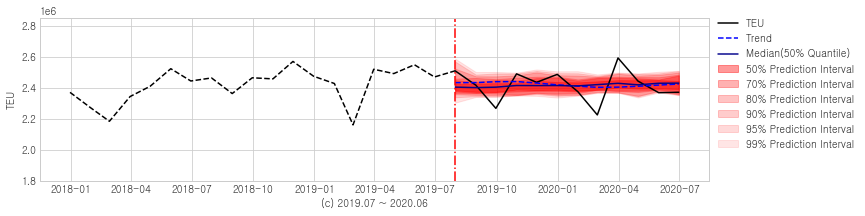

In [97]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.85e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='red', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='red', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='red', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='red', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='red', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [98]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 1.0


In [99]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 81377.5
Quantile 70% Interval Sharpness 77200.09166666663


RMSE: 98037.09261122272
MAPE: 3.2546540915266626


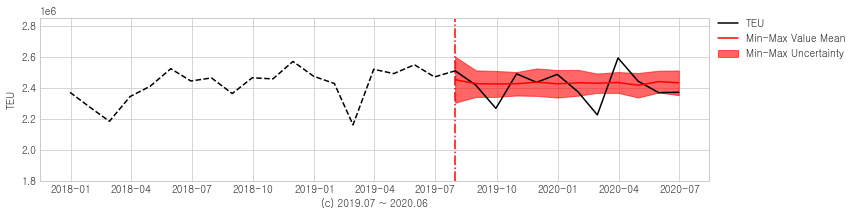

In [100]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.85e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='red',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='red',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [101]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666


In [102]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 162755.08
Quantile 95% Interval Sharpness 144559.6973958333
Min Max Interval Sharpness 168389.98


In [103]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[24:36].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

74451.97638888888
11088.386111111111
119061.87555555557
54428.615000000005
13829.550000000003
45962.98305555555
23254.83444444445
177538.7691666667
140927.92416666666
14045.566388888888
41373.891666666685
35311.527222222234


In [104]:
a = np.array([74451.97638888888,
11088.386111111111,
119061.87555555557,
54428.615000000005,
13829.550000000003,
45962.98305555555,
23254.83444444445,
177538.7691666667,
140927.92416666666,
14045.566388888888,
41373.891666666685,
35311.527222222234])

In [105]:
np.mean(a)

62606.32493055556

In [106]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2420231.8

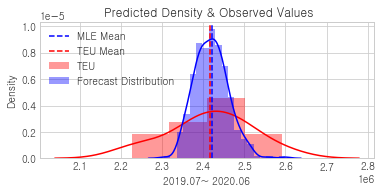

In [107]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[24:36].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[24:36].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2020.06')
plt.legend(loc=2)

In [108]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[24:36].reset_index()['TEU'].mean(), scale=test_data.iloc[24:36].reset_index()['TEU'].std() ) )
LL

4513.620718406299

In [109]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

8962.827292919552

In [110]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[24:36].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

1154.0299121477608

In [111]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[24:36].reset_index()['TEU']))

32633.820155496458
50964.365849159934
380985.73438846157
63811.25016360701
212098.20282088232
98097.16506437221
601145.4782553171
139271.69631661585
50738.72236626444
615509.3969389014
279237.5734488014
82024.38331456506
43939.96004733913
370454.1370620481
117976.88212219438
225989.44706546635
584616.1887328664
485024.8694900731
202476.27154492977
8651.81685605162
3292.408997001272
468420.57209037367
338847.2008625614
438601.8905832044
382549.30857820995
65064.65180386825
471033.756277615
889193.2992483927
413692.68653611135
322409.5034303827


In [112]:
a = np.array([32633.820155496458,
50964.365849159934,
380985.73438846157,
63811.25016360701,
212098.20282088232,
98097.16506437221,
601145.4782553171,
139271.69631661585,
50738.72236626444,
615509.3969389014,
279237.5734488014,
82024.38331456506,
43939.96004733913,
370454.1370620481,
117976.88212219438,
225989.44706546635,
584616.1887328664,
485024.8694900731,
202476.27154492977,
8651.81685605162,
3292.408997001272,
468420.57209037367,
338847.2008625614,
438601.8905832044,
382549.30857820995,
65064.65180386825,
471033.756277615,
889193.2992483927,
413692.68653611135,
322409.5034303827])

In [113]:
np.mean(a)

281291.7546803711

### 4. 2020.07 ~ 2021.06

In [48]:
X_test_4 = np.array(feature_test[36:54]).reshape((1, 18, 10)) 

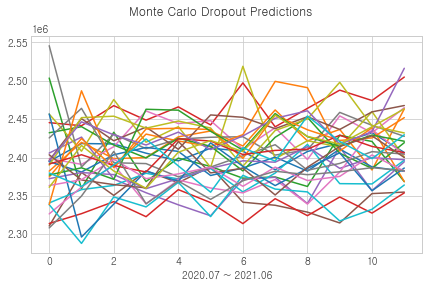

In [49]:
model_MC=  model
prediction = [model_MC.predict(X_test_4) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2020.07 ~ 2021.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [50]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [51]:
np.mean(df.std()/df.mean())

0.011101875454187393

In [53]:
df.to_csv('Attention1.csv')

In [118]:
rmse = math.sqrt(mean_squared_error(trend[36:48].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[36:48].reset_index()['TEU_Trend']- df.transpose().median())/ trend[36:48].reset_index()['TEU_Trend'])*100) )

RMSE: 78305.32705566291
MAPE: 2.98130215740918


In [119]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[36:48]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-31,2394881.75,2382271.0,2503558.25,2445446.0,2405798.0,2310810.5,2398513.75,2545733.0,2456583.75,2340772.75,2394560.75,2374665.25,2432265.25,2314007.5,2372422.0,2396294.75,2326511.25,2425543.5,2390088.5,2338580.0,2456776.5,2338717.0,2377149.0,2391525.25,2395629.5,2403546.5,2363464.25,2308236.75,2361220.5,2379764.5


In [120]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:258]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2021-06-30,2507761,3383,3.40973,3.569689,4.537851,117.6,8830.5,1121.3,130920264,107.4


Mean RMSE: 147407.0602108855
Mean MAPE: 5.051812387264904


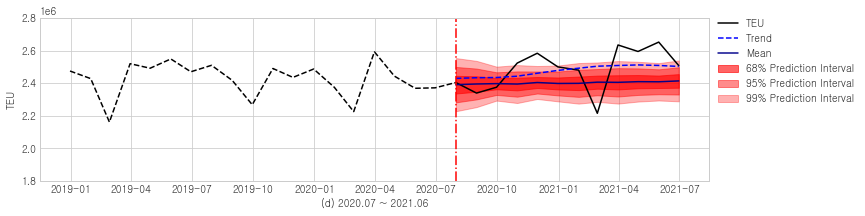

In [121]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='red', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='red',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [122]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.3333333333333333
추세 변동에 대한 포함확률: 0.16666666666666666


Median RMSE: 144127.701194074
Median MAPE: 4.945049373395411


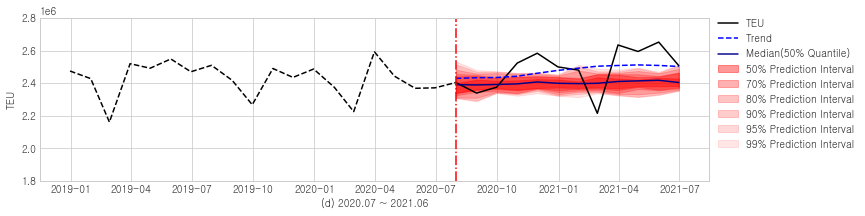

In [123]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='red', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='red', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='red', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='red', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='red', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [124]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.4166666666666667
추세 변동에 대한 포함확률: 0.16666666666666666


In [125]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 81840.29
Quantile 70% Interval Sharpness 80142.39583333337


RMSE: 148978.1667087007
MAPE: 5.078135087467746


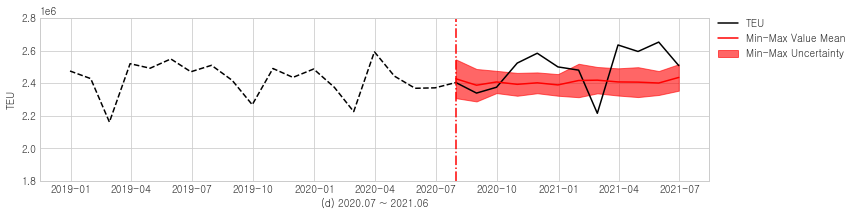

In [126]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='red',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='red',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [127]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.4166666666666667


In [128]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 163680.45
Quantile 95% Interval Sharpness 148055.64739583328
Min Max Interval Sharpness 166563.58


In [129]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[36:48].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

13559.12972222222
36806.952777777784
12871.01277777778
106704.69111111111
160665.96777777778
81283.02416666667
63254.06416666667
168505.4352777778
204748.73416666666
163741.39750000002
222329.255
71832.6961111111


In [130]:
a = np.array([13559.12972222222,
36806.952777777784,
12871.01277777778,
106704.69111111111,
160665.96777777778,
81283.02416666667,
63254.06416666667,
168505.4352777778,
204748.73416666666,
163741.39750000002,
222329.255,
71832.6961111111])

In [131]:
np.mean(a)

108858.53004629629

In [132]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2402224.0

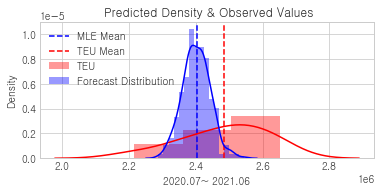

In [133]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[36:48].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2020.07~ 2021.06')
plt.legend(loc=2)

In [134]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[36:48].reset_index()['TEU'].mean(), scale=test_data.iloc[36:48].reset_index()['TEU'].std() ) )
LL

4660.300635289074

In [135]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

9723.339816886903

In [136]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[36:48].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

2845.397325030759

In [137]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[36:48].reset_index()['TEU']))

858709.2503899505
711371.0594893647
968844.7262852937
194429.7251548529
1260225.1559128182
1515764.9022082184
610682.804107827
568289.7970138146
562856.2792308094
1264450.9768179301
1024102.8914838161
667850.4607721722
755682.7523027294
1696967.6149228157
1114531.6614497635
486188.15835680853
1306375.2288686694
901914.2524501886
502521.9089731571
1615894.8728315227
1196966.8701121942
643835.3531061711
710185.21809363
873803.965161978
523879.39936045057
1090872.439708744
1192316.3453945199
1337217.6914383688
796758.4020135467
948742.2394795968


In [138]:
a = np.array([858709.2503899505,
711371.0594893647,
968844.7262852937,
194429.7251548529,
1260225.1559128182,
1515764.9022082184,
610682.804107827,
568289.7970138146,
562856.2792308094,
1264450.9768179301,
1024102.8914838161,
667850.4607721722,
755682.7523027294,
1696967.6149228157,
1114531.6614497635,
486188.15835680853,
1306375.2288686694,
901914.2524501886,
502521.9089731571,
1615894.8728315227,
1196966.8701121942,
643835.3531061711,
710185.21809363,
873803.965161978,
523879.39936045057,
1090872.439708744,
1192316.3453945199,
1337217.6914383688,
796758.4020135467,
948742.2394795968])

In [139]:
np.mean(a)

930074.4134297242

### 5. 2021.07 ~ 2022.06

In [54]:
X_test_5 = np.array(feature_test[48:66]).reshape((1, 18, 10)) 

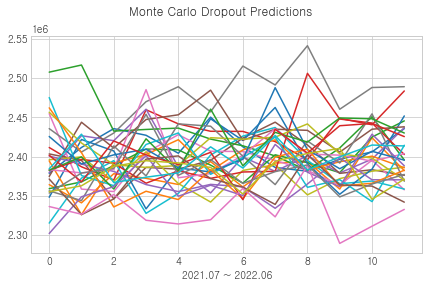

In [55]:
model_MC=  model
prediction = [model_MC.predict(X_test_5) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2021.07 ~ 2022.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [56]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [57]:
np.mean(df.std()/df.mean())

0.012369068339467049

In [58]:
df.to_csv('Attention2.csv')

In [144]:
rmse = math.sqrt(mean_squared_error(trend[48:60].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[48:60].reset_index()['TEU_Trend']- df.transpose().median())/ trend[48:60].reset_index()['TEU_Trend'])*100) )

RMSE: 109189.4624217194
MAPE: 4.319932425070545


In [145]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[48:60]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-31,2378679.5,2364209.0,2359038.0,2411619.25,2379665.25,2403416.5,2454815.75,2435748.5,2395983.75,2315071.5,2348069.5,2394469.5,2507852.5,2382668.75,2400665.75,2374648.75,2383331.5,2356241.0,2456637.0,2475402.25,2425687.75,2462246.5,2382630.25,2401684.25,2301781.5,2371298.5,2336202.25,2353427.5,2355122.75,2384438.75


In [146]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2022-06-30,2324505,2240,3.749211,3.625297,4.488265,120.1,5609.8,1277.35,118631016,132.61


Mean RMSE: 133646.82336487027
Mean MAPE: 4.306886720356301


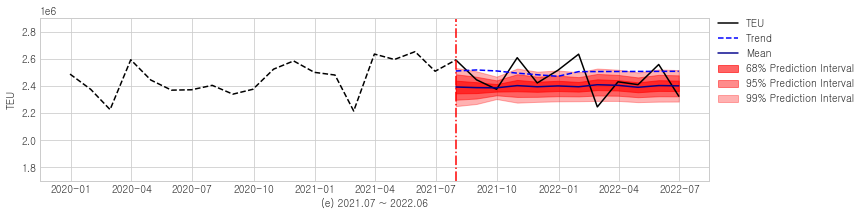

In [147]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='darkblue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='red', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='red',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(12).reset_index()['TEU'])*100) )

In [148]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5
추세 변동에 대한 포함확률: 0.0


In [149]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 76476.086
Quantile 70% Interval Sharpness 69955.43645833335


Median RMSE: 134733.81617702736
Median MAPE: 4.376564268993321


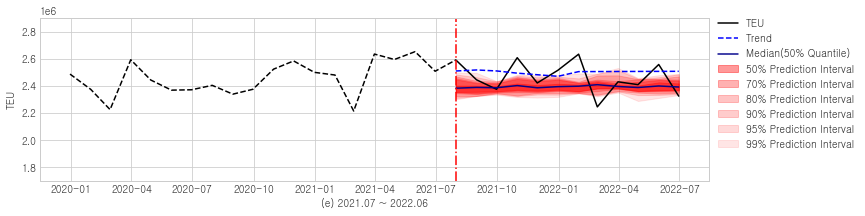

In [150]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='blue',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='darkblue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='red', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='red', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='red', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='red', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='red', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='red', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.tail(12).reset_index()['TEU'])*100) )

In [151]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.4166666666666667
추세 변동에 대한 포함확률: 0.0


RMSE: 126452.15985714305
MAPE: 4.057658986970016


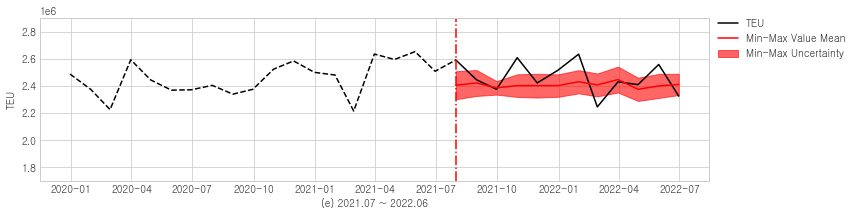

In [152]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Min Max Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')

plt.plot((df2.transpose().max()+df2.transpose().min())/2,color='red',label='Min-Max Value Mean')
plt.plot((df2.transpose().max()+df2.transpose().min())/2 - (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.plot((df2.transpose().max()+df2.transpose().min())/2 + (df2.transpose().max()-df2.transpose().min())/2,color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index,df2.transpose().min(),df2.transpose().max(),color='red',alpha=0.6, label='Min-Max Uncertainty')
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], (df.transpose().max()+df.transpose().min())/2))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- (df.transpose().max()+df.transpose().min())/2)/ test_data.tail(12).reset_index()['TEU'])*100) )

plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

In [153]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.4166666666666667


In [154]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 152952.33
Quantile 95% Interval Sharpness 135853.52812499992
Min Max Interval Sharpness 169965.89


In [155]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[48:60].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

173703.39777777778
41403.64611111111
8570.895833333332
182101.38611111112
19229.24111111111
94508.35055555556
221480.50722222222
141512.16500000004
21728.3025
13652.425833333333
133094.63972222223
54698.85250000001


In [156]:
a =np.array([173703.39777777778,
41403.64611111111,
8570.895833333332,
182101.38611111112,
19229.24111111111,
94508.35055555556,
221480.50722222222,
141512.16500000004,
21728.3025,
13652.425833333333,
133094.63972222223,
54698.85250000001])

In [157]:
np.mean(a)

92140.31752314814

In [158]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2396539.8

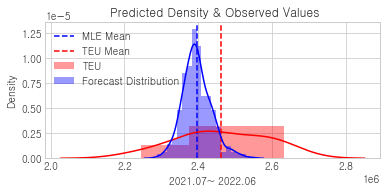

In [159]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[48:60].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[48:60].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2021.07~ 2022.06')
plt.legend(loc=2)

In [160]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[48:60].reset_index()['TEU'].mean(), scale=test_data.iloc[48:60].reset_index()['TEU'].std() ) )
LL

4614.516338696615

In [161]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

8486.452108806514

In [162]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[48:60].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

2078.133426010749

In [163]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[48:60].reset_index()['TEU']))

589756.7456287218
978583.000172444
771922.080525489
395581.7869297202
690751.5276206916
779598.2317154467
808398.9959074849
156462.42523260028
966051.8741884427
978587.7213978284
691036.8637884553
798876.7925590044
320074.431964051
655504.6312060347
1049281.520074752
334179.55053698167
689617.7052520011
743950.8322665371
595300.2832194376
760824.5415893015
633578.0128692656
950500.3537137643
542077.3048551296
627392.5347925387
1044296.163204806
1121331.140673645
1509949.1594615385
936916.9062000196
944258.9205196587
738910.1635323244


In [164]:
a = np.array([589756.7456287218,
978583.000172444,
771922.080525489,
395581.7869297202,
690751.5276206916,
779598.2317154467,
808398.9959074849,
156462.42523260028,
966051.8741884427,
978587.7213978284,
691036.8637884553,
798876.7925590044,
320074.431964051,
655504.6312060347,
1049281.520074752,
334179.55053698167,
689617.7052520011,
743950.8322665371,
595300.2832194376,
760824.5415893015,
633578.0128692656,
950500.3537137643,
542077.3048551296,
627392.5347925387,
1044296.163204806,
1121331.140673645,
1509949.1594615385,
936916.9062000196,
944258.9205196587,
738910.1635323244])

In [165]:
np.mean(a)

760118.4067199372